In [34]:
from __future__ import annotations
import torch
from typing import Any, Tuple
from botorch.models.model import Model
from botorch.models import FixedNoiseGP, SingleTaskGP
from botorch import fit_gpytorch_model
from botorch.posteriors import Posterior
from botorch.models.transforms import Standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch import Tensor
from typing import List, Optional
from botorch.acquisition import MCAcquisitionFunction
from botorch.acquisition.objective import MCAcquisitionObjective
from botorch.sampling.base import MCSampler
from botorch.utils.transforms import concatenate_pending_points, t_batch_mode_transform
from torch import Tensor
import gpytorch

class GaussianProcessNetwork(Model):
    r"""
    Fits a GP model to the provided data given the graph structure.
    """

    def __init__(self, train_X, train_Y, dag, active_input_indices, train_Yvar=None, node_GPs=None, normalization_constant_lower=None, normalization_constant_upper=None) -> None:
        r"""
        """
        self.train_X = train_X
        self.train_Y = train_Y
        self.dag = dag
        self.n_nodes = dag.get_n_nodes()
        self.root_nodes = dag.get_root_nodes()
        self.active_input_indices = active_input_indices
        self.train_Yvar = train_Yvar
        self.noise_var = 1e-5

        if node_GPs is not None:
            self.node_GPs = node_GPs
            self.normalization_constant_lower = normalization_constant_lower
            self.normalization_constant_upper = normalization_constant_upper
        else:
            self.node_GPs = [None for k in range(self.n_nodes)]
            self.node_mlls = [None for k in range(self.n_nodes)]
            self.normalization_constant_lower = [[None for j in range(len(self.dag.get_parent_nodes(k)))] for k in range(self.n_nodes)]
            self.normalization_constant_upper = [[None for j in range(len(self.dag.get_parent_nodes(k)))] for k in range(self.n_nodes)]

            for k in self.root_nodes:
                if self.active_input_indices is not None:
                    train_X_node_k = train_X[..., self.active_input_indices[k]]
                else:
                    train_X_node_k = train_X
                train_Y_node_k = train_Y[..., [k]]
                self.node_GPs[k] = SingleTaskGP(train_X=train_X_node_k, train_Y=train_Y_node_k, train_Yvar=torch.ones(train_Y_node_k.shape) * self.noise_var, outcome_transform=Standardize(m=1), covar_module=gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims = train_X_node_k.shape[1])))
                # self.node_GPs[k] = FixedNoiseGP(train_X=train_X_node_k, train_Y=train_Y_node_k, train_Yvar=torch.ones(train_Y_node_k.shape) * self.noise_var, outcome_transform=Standardize(m=1), covar_module=gpytorch.kernels.RBFKernel(ard_num_dims = train_X_node_k.shape[1]))
                self.node_mlls[k] = ExactMarginalLogLikelihood(self.node_GPs[k].likelihood, self.node_GPs[k])
                fit_gpytorch_model(self.node_mlls[k])

            for k in range(self.n_nodes):
                if self.node_GPs[k] is None:
                    aux = train_Y[..., self.dag.get_parent_nodes(k)].clone()
                    for j in range(len(self.dag.get_parent_nodes(k))):
                        self.normalization_constant_lower[k][j] = torch.min(aux[..., j])
                        self.normalization_constant_upper[k][j] = torch.max(aux[..., j])
                        aux[..., j] = (aux[..., j] - self.normalization_constant_lower[k][j])/(self.normalization_constant_upper[k][j] - self.normalization_constant_lower[k][j])
                    train_X_node_k = torch.cat([train_X[..., self.active_input_indices[k]], aux], -1)
                    train_Y_node_k = train_Y[..., [k]]
                    # aux_model =  FixedNoiseGP(train_X=train_X_node_k, train_Y=train_Y_node_k, train_Yvar=torch.ones(train_Y_node_k.shape) * self.noise_var, outcome_transform=Standardize(m=1))
                    # batch_shape = aux_model._aug_batch_shape
                    self.node_GPs[k] = SingleTaskGP(train_X=train_X_node_k, train_Y=train_Y_node_k, train_Yvar=torch.ones(train_Y_node_k.shape) * self.noise_var, outcome_transform=Standardize(m=1, batch_shape=torch.Size([])), covar_module=gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims = train_X_node_k.shape[1])))
                    # self.node_GPs[k] = FixedNoiseGP(train_X=train_X_node_k, train_Y=train_Y_node_k, train_Yvar=torch.ones(train_Y_node_k.shape) * 1e-6, outcome_transform=Standardize(m=1, batch_shape=torch.Size([1])))
                    # self.node_GPs[k] = FixedNoiseGP(train_X=train_X_node_k, train_Y=train_Y_node_k, train_Yvar=torch.ones(train_Y_node_k.shape) * self.noise_var, outcome_transform=Standardize(m=1, batch_shape=torch.Size([])))
                    self.node_mlls[k] = ExactMarginalLogLikelihood(self.node_GPs[k].likelihood, self.node_GPs[k])
                    fit_gpytorch_model(self.node_mlls[k])

    def get_train_data_node_k(self, k):
        train_X = self.train_X
        train_Y = self.train_Y
        aux = train_Y[..., self.dag.get_parent_nodes(k)].clone()
        for j in range(len(self.dag.get_parent_nodes(k))):
            self.normalization_constant_lower[k][j] = torch.min(aux[..., j])
            self.normalization_constant_upper[k][j] = torch.max(aux[..., j])
            aux[..., j] = (aux[..., j] - self.normalization_constant_lower[k][j])/(self.normalization_constant_upper[k][j] - self.normalization_constant_lower[k][j])
        train_X_node_k = torch.cat([train_X[..., self.active_input_indices[k]], aux], -1)
        train_Y_node_k = train_Y[..., [k]]
        train_Yvar_node_k = torch.ones(train_Y_node_k.shape) * self.noise_var
        return train_X_node_k, train_Y_node_k, train_Yvar_node_k

    def posterior(self, X: Tensor, posterior_transform=None, observation_noise=False) -> MultivariateNormalNetwork:
        r"""Computes the posterior over model outputs at the provided points.
        Args:
            X: A `(batch_shape) x q x d`-dim Tensor, where `d` is the dimension
                of the feature space and `q` is the number of points considered
                jointly.
            observation_noise: If True, add the observation noise from the
                likelihood to the posterior. If a Tensor, use it directly as the
                observation noise (must be of shape `(batch_shape) x q`).
        Returns:
            A `GPyTorchPosterior` object, representing a batch of `b` joint
            distributions over `q` points. Includes observation noise if
            specified.
        """
        return MultivariateNormalNetwork(self.node_GPs, self.dag, X, self.active_input_indices, self.normalization_constant_lower, self.normalization_constant_upper)

    def forward(self, x: Tensor) -> MultivariateNormalNetwork:
        return MultivariateNormalNetwork(self.node_GPs, self.dag, x, self.active_input_indices, self.normalization_constant)

    def condition_on_observations(self, X: Tensor, Y: Tensor, **kwargs: Any) -> Model:
        r"""Condition the model on new observations.
        Args:
            X: A `batch_shape x n' x d`-dim Tensor, where `d` is the dimension of
                the feature space, `n'` is the number of points per batch, and
                `batch_shape` is the batch shape (must be compatible with the
                batch shape of the model).
            Y: A `batch_shape' x n' x m`-dim Tensor, where `m` is the number of
                model outputs, `n'` is the number of points per batch, and
                `batch_shape'` is the batch shape of the observations.
                `batch_shape'` must be broadcastable to `batch_shape` using
                standard broadcasting semantics. If `Y` has fewer batch dimensions
                than `X`, it is assumed that the missing batch dimensions are
                the same for all `Y`.
        Returns:
            A `Model` object of the same type, representing the original model
            conditioned on the new observations `(X, Y)` (and possibly noise
            observations passed in via kwargs).
        """
        fantasy_models = [None for k in range(self.n_nodes)]

        for k in self.root_nodes:
            if self.active_input_indices is not None:
                X_node_k = X[..., self.active_input_indices[k]]
            else:
                X_node_k = X
            Y_node_k = Y[..., [k]]
            fantasy_models[k] = self.node_GPs[k].condition_on_observations(X_node_k, Y_node_k, noise=torch.ones(Y_node_k.shape[1:]) * self.noise_var)

        for k in range(self.n_nodes):
            if fantasy_models[k] is None:
                aux = Y[..., self.dag.get_parent_nodes(k)].clone()
                for j in range(len(self.dag.get_parent_nodes(k))):
                    aux[..., j] = (aux[..., j] - self.normalization_constant_lower[k][j])/(self.normalization_constant_upper[k][j] - self.normalization_constant_lower[k][j])
                aux_shape = [aux.shape[0]] + [1] * X[..., self.active_input_indices[k]].ndim
                X_aux = X[..., self.active_input_indices[k]].unsqueeze(0).repeat(*aux_shape)
                X_node_k = torch.cat([X_aux, aux], -1)
                Y_node_k = Y[..., [k]]
                fantasy_models[k] = self.node_GPs[k].condition_on_observations(X_node_k, Y_node_k, noise=torch.ones(Y_node_k.shape[1:]) * self.noise_var)

        return GaussianProcessNetwork(dag=self.dag, train_X=X, train_Y=Y, active_input_indices=self.active_input_indices, node_GPs=fantasy_models, normalization_constant_lower=self.normalization_constant_lower, normalization_constant_upper=self.normalization_constant_upper)

class MultivariateNormalNetwork(Posterior):
    def __init__(self, node_GPs, dag, X, indices_X=None, normalization_constant_lower=None, normalization_constant_upper=None):
        self.node_GPs = node_GPs
        self.dag = dag
        self.n_nodes = dag.get_n_nodes()
        self.root_nodes = dag.get_root_nodes()
        self.X = X
        self.active_input_indices = indices_X
        self.normalization_constant_lower = normalization_constant_lower
        self.normalization_constant_upper = normalization_constant_upper

    @property
    def device(self) -> torch.device:
        r"""The torch device of the posterior."""
        return "cpu"

    @property
    def dtype(self) -> torch.dtype:
        r"""The torch dtype of the posterior."""
        return torch.double

    @property
    def event_shape(self) -> torch.Size:
        r"""The event shape (i.e. the shape of a single sample) of the posterior."""
        shape = list(self.X.shape)
        shape[-1] = self.n_nodes
        shape = torch.Size(shape)
        return shape

    @property
    def base_sample_shape(self) -> torch.Size:
        r"""The base shape of the base samples expected in `rsample`.

        Informs the sampler to produce base samples of shape
        `sample_shape x base_sample_shape`.
        """
        shape = torch.Size(list([1,1,self.n_nodes]))
        return shape

    @property
    def batch_range(self) -> Tuple[int, int]:
        r"""The t-batch range.

        This is used in samplers to identify the t-batch component of the
        `base_sample_shape`. The base samples are expanded over the t-batches to
        provide consistency in the acquisition values, i.e., to ensure that a
        candidate produces same value regardless of its position on the t-batch.
        """
        return (0, -1)

    def rsample_from_base_samples(self, sample_shape: torch.Size, base_samples: Tensor) -> Tensor:
        return self.rsample(sample_shape, base_samples)

    def rsample(self, sample_shape=torch.Size(), base_samples=None):
        #t0 =  time.time()
        nodes_samples = torch.empty(sample_shape + self.event_shape)
        nodes_samples = nodes_samples.double()
        nodes_samples_available = [False for k in range(self.n_nodes)]
        for k in self.root_nodes:
            #t0 =  time.time()
            if self.active_input_indices is not None:
                X_node_k = self.X[..., self.active_input_indices[k]]
            else:
                X_node_k = self.X
            multivariate_normal_at_node_k = self.node_GPs[k].posterior(X_node_k)
            if base_samples is not None:
                nodes_samples[..., k] = multivariate_normal_at_node_k.rsample(sample_shape, base_samples=base_samples[..., [k]])[..., 0]
            else:
                nodes_samples[..., k] = multivariate_normal_at_node_k.rsample(sample_shape)[..., 0]
            nodes_samples_available[k] = True
            #t1 = time.time()
            #print('Part A of the code took: ' + str(t1 - t0))

        while not all(nodes_samples_available):
            for k in range(self.n_nodes):
                parent_nodes = self.dag.get_parent_nodes(k)
                if not nodes_samples_available[k] and all([nodes_samples_available[j] for j in parent_nodes]):
                    #t0 =  time.time()
                    parent_nodes_samples_normalized = nodes_samples[..., parent_nodes].clone()
                    for j in range(len(parent_nodes)):
                        parent_nodes_samples_normalized[..., j] = (parent_nodes_samples_normalized[..., j] - self.normalization_constant_lower[k][j])/(self.normalization_constant_upper[k][j] - self.normalization_constant_lower[k][j])
                    X_node_k = self.X[..., self.active_input_indices[k]]
                    aux_shape = [sample_shape[0]] + [1] * X_node_k.ndim
                    X_node_k = X_node_k.unsqueeze(0).repeat(*aux_shape)
                    X_node_k = torch.cat([X_node_k, parent_nodes_samples_normalized], -1)
                    multivariate_normal_at_node_k = self.node_GPs[k].posterior(X_node_k)
                    if base_samples is not None:
                        #print(torch.sqrt(multivariate_normal_at_node_k.variance).shape)
                        #print(torch.flatten(base_samples[..., k]).shape)
                        my_aux = torch.sqrt(multivariate_normal_at_node_k.variance)
                        #print(my_aux.ndim)
                        if my_aux.ndim == 4:
                            nodes_samples[...,k] = (multivariate_normal_at_node_k.mean + torch.einsum('abcd,a->abcd', torch.sqrt(multivariate_normal_at_node_k.variance), torch.flatten(base_samples[..., k])))[..., 0]
                        elif my_aux.ndim == 5:
                            nodes_samples[...,k] = (multivariate_normal_at_node_k.mean + torch.einsum('abcde,a->abcde', torch.sqrt(multivariate_normal_at_node_k.variance), torch.flatten(base_samples[..., k])))[..., 0]
                        else:
                            print("error")
                    else:
                        nodes_samples[..., k] = multivariate_normal_at_node_k.rsample()[0, ..., 0]
                    nodes_samples_available[k] = True
                    #t1 = time.time()
                    #print('Part B of the code took: ' + str(t1 - t0))
        #t1 = time.time()
        #print('Taking this sample took: ' + str(t1 - t0))
        return nodes_samples

class DAG(object):

    def __init__(self, parent_nodes:List[List[Optional[int]]]):
        self.parent_nodes = parent_nodes
        self.n_nodes = len(parent_nodes)
        self.root_nodes = []
        for k in range(self.n_nodes):
            if len(parent_nodes[k]) == 0:
                self.root_nodes.append(k)

    def get_n_nodes(self):
        return self.n_nodes

    def get_parent_nodes(self, k):
        return self.parent_nodes[k]

    def get_root_nodes(self):
        return self.root_nodes

def generate_initial_design(num_samples: int, input_dim: int, seed=None):
    # generate training data
    if seed is not None:
        old_state = torch.random.get_rng_state()
        torch.manual_seed(seed)
        X = torch.rand([num_samples, input_dim])
        torch.random.set_rng_state(old_state)
    else:
        X = torch.rand([num_samples, input_dim])
    return X

class PosteriorMean(MCAcquisitionFunction):
    """
    """

    def __init__(
        self,
        model: Model,
        sampler: Optional[MCSampler] = None,
        objective: Optional[MCAcquisitionObjective] = None,
        X_pending: Optional[Tensor] = None,
    ) -> None:
        r"""
        """
        super().__init__(
            model=model, sampler=sampler, objective=objective, X_pending=X_pending
        )

    @concatenate_pending_points
    @t_batch_mode_transform()
    def forward(self, X: Tensor) -> Tensor:
        r"""
        """
        posterior = self.model.posterior(X)
        samples = self.sampler(posterior)
        obj = self.objective(samples)
        obj = obj.mean(dim=0)[..., 0]
        return obj

In [35]:
import numpy as np
import torch
from math import pi

class EfficientThompsonSampler():
    def __init__(self, model, num_of_multistarts = 1, num_of_bases = 1024, num_of_samples = 1):
        '''
        Implementation of 'Efficiently Sampling From Gaussian Process Posteriors' by Wilson et al. (2020). It allows
        us to create approximate samples of the GP posterior, which we can optimise using gradient methods. We do this
        to generate candidates using Thompson Sampling. Link to the paper: https://arxiv.org/pdf/2002.09309.pdf .
        '''
        # GP model
        self.model = model
        # inputs
        if type(self.model.train_x) == torch.Tensor:
            self.train_x = self.model.train_x
        else:
            self.train_x = torch.tensor(self.model.train_x)
        self.x_dim = torch.tensor(self.train_x.shape[1])
        self.train_y = self.model.train_y
        self.num_of_train_inputs = self.model.train_x.shape[0]
        # thompson sampling parameters
        self.num_of_multistarts = num_of_multistarts
        self.num_of_bases = num_of_bases
        self.num_of_samples = num_of_samples
        # optimisation parameters
        self.learning_rate = 0.01
        self.num_of_epochs = 10 * self.x_dim
        # obtain the kernel parameters
        self.sigma = self.model.likelihood.noise[0].item() # assumes fixed noise value
        self.lengthscale = self.model.covar_module.base_kernel.lengthscale.detach().float()
        self.outputscale = self.model.covar_module.outputscale.item()
        # obtain the kernel
        self.kernel = self.model.covar_module
        # define the Knn matrix
        with torch.no_grad():
            self.Knn = self.kernel(self.train_x)
            self.Knn = self.Knn.evaluate()
            # precalculate matrix inverse
            self.inv_mat = torch.inverse(self.Knn + self.sigma * torch.eye(self.num_of_train_inputs))

        self.create_fourier_bases()
        self.calculate_phi()

    def create_fourier_bases(self):
        # sample thetas
        self.thetas = torch.randn(size = (self.num_of_bases, self.x_dim)) / self.lengthscale
        # sample biases
        self.biases = torch.rand(self.num_of_bases) * 2 * pi

    def create_sample(self):
        # sample weights
        self.weights = torch.randn(size = (self.num_of_samples, self.num_of_bases)).float()

    def calculate_phi(self):
        '''
        From the paper, we are required to calculate a matrix which includes the evaluation of the training set, X_train,
        at the fourier frequencies. This function calculates that matrix, Phi.
        '''
        # we take the dot product by element-wise multiplication followed by summation
        thetas = self.thetas.repeat(self.num_of_train_inputs, 1, 1)
        prod = thetas * self.train_x.unsqueeze(1)
        dot = torch.sum(prod, axis = -1)
        # add biases and take cosine to obtain fourier representations
        ft = torch.cos(dot + self.biases.unsqueeze(0))
        # finally, multiply by corresponding constants (see paper)
        self.Phi = (self.outputscale * np.sqrt(2 / self.num_of_bases) * ft).float()

    def calculate_V(self):
        '''
        From the paper, to give posterior updates we need to calculate the vector V. Since we are doing multiple samples
        at the same time, V will be a matrix. We can pre-calculate it, since its value does not depend on the query locations.
        '''
        # multiply phi matrix by weights
        # PhiW: num_of_train x num_of_samples
        PhiW = torch.matmul(self.Phi, self.weights.T)
        # add noise (see paper)
        PhiW = PhiW + torch.randn(size = PhiW.shape) * self.sigma
        # subtract from training outputs
        mat1 = self.train_y - PhiW
        # calculate V matrix by premultiplication by inv_mat = (K_nn + I_n*sigma)^{-1}
        # V: num_of_train x num_of_samples
        self.V = torch.matmul(self.inv_mat, mat1)

    def calculate_fourier_features(self, x):
        '''
        Calculate the Fourier Features evaluated at some input x
        '''
        # evaluation using fourier features
        self.posterior_update(x)
        # calculate the dot product between the frequencies, theta, and the new query points
        dot = x.matmul(self.thetas.T)
        # calculate the fourier frequency by adding bias and cosine
        ft = torch.cos(dot + self.biases.unsqueeze(0))
        # apply the normalising constants and return the output
        return self.outputscale * np.sqrt(2 / self.num_of_bases) * ft

    def sample_prior(self, x):
        '''
        Create a sample form the prior, evaluate it at x
        '''
        if type(x) is not torch.Tensor:
            x = torch.tensor(x)
        # calculate the fourier features evaluated at the query points
        out1 = self.calculate_fourier_features(x)
        # extend the weights so that we can use element wise multiplication
        weights = self.weights.repeat(self.num_of_multistarts, 1, 1)
        # return the prior
        return torch.sum(weights * out1, axis = -1)

    def posterior_update(self, x):
        '''
        Calculate the posterior update at a location x
        '''
        if type(x) is not torch.Tensor:
            x = torch.tensor(x)
        # x: num_of_multistarts x num_of_samples x dim
        self.calculate_V() # can probably pre-calculate this
        # train x: num_of_multistarts x num_of_train x dim
        train_x = self.train_x.repeat(self.num_of_multistarts, 1, 1)
        # z: num_of_multistarts x num_of_train x num_of_samples
        # z: kernel evaluation between new query points and training set
        z = self.kernel(train_x, x)
        z = z.evaluate()
        # we now repeat V the number of times necessary so that we can use element-wise multiplication
        V = self.V.repeat(self.num_of_multistarts, 1, 1)
        out = z * V
        return out.sum(axis = 1) # we return the sum across the number of training point, as per the paper

    def query_sample(self, x):
        '''
        Query the sample at a location
        '''
        prior = self.sample_prior(x)
        update = self.posterior_update(x)
        return prior + update

    def generate_candidates(self):
        '''
        Generate the Thompson Samples, this function optimizes the samples.
        '''
        # we are always working on [0, 1]^d
        bounds = torch.stack([torch.zeros(self.x_dim), torch.ones(self.x_dim)])
        # initialise randomly - there is definitely much better ways of doing this
        X = torch.rand(self.num_of_multistarts, self.num_of_samples, self.x_dim)
        X.requires_grad = True
        # define optimiser
        optimiser = torch.optim.Adam([X], lr = self.learning_rate)

        for _ in range(self.num_of_epochs):
            # set zero grad
            optimiser.zero_grad()
            # evaluate loss and backpropagate
            losses = - self.query_sample(X)
            loss = losses.sum()
            loss.backward()
            # take step
            optimiser.step()

            # make sure we are still within the bounds
            for j, (lb, ub) in enumerate(zip(*bounds)):
                X.data[..., j].clamp_(lb, ub) # need to do this on the data not X itself
        # check the final evaluations
        final_evals = self.query_sample(X)
        # choose the best one for each sample
        best_idx = torch.argmax(final_evals, axis = 0)
        # return the best one for each sample, without gradients
        X_out = X[best_idx, range(0, self.num_of_samples), :]
        return X_out.detach()

In [255]:
# Gaussian process network example 1
import torch
from botorch.acquisition.objective import GenericMCObjective
from botorch.settings import debug
from torch import Tensor
from botorch.acquisition import ExpectedImprovement, qExpectedImprovement
from botorch.acquisition import PosteriorMean as GPPosteriorMean
from botorch.sampling.normal import SobolQMCNormalSampler
import time

if False:

    class Dropwave:
        def __init__(self):
            self.n_nodes = 2
            self.input_dim = 2

        def evaluate(self, X):
            X_scaled = 10.24 * X - 5.12
            input_shape = X_scaled.shape
            output = torch.empty(input_shape[:-1] + torch.Size([self.n_nodes]))
            norm_X = torch.norm(X_scaled, dim=-1)
            output[..., 0] = norm_X
            output[..., 1] = (1.0 + torch.cos(12.0 * norm_X)) /(2.0 + 0.5 * (norm_X ** 2))
            return output

    torch.set_default_dtype(torch.float64)
    debug._set_state(True)

    dropwave = Dropwave()
    input_dim = dropwave.input_dim
    n_nodes = 2
    problem = 'dropwave'

    def function_network(X: Tensor):
        return dropwave.evaluate(X=X)

    # Underlying DAG
    parent_nodes = []
    parent_nodes.append([])
    parent_nodes.append([0])
    dag = DAG(parent_nodes=parent_nodes)

    # Active input indices
    active_input_indices = [[0, 1], []]

    # Function that maps the network output to the objective value
    network_to_objective_transform = lambda Y: Y[..., -1]
    network_to_objective_transform = GenericMCObjective(network_to_objective_transform)

else:

    class SinWave:
        def __init__(self):
            self.n_nodes = 2
            self.input_dim = 2

        def evaluate(self, X):
            input_shape = X.shape
            output = torch.empty(input_shape[:-1] + torch.Size([self.n_nodes]))
            output[..., 0] = torch.sin(2*X[..., 0]) + X[..., 1]
            output[..., 1] = 2.0*output[..., 0]**2 + (X[..., 1] - 0.5)**2
            return output

    torch.set_default_dtype(torch.float64)
    debug._set_state(True)

    sinwave = SinWave()
    input_dim = sinwave.input_dim
    n_nodes = 2
    problem = 'sinwave'

    def function_network(X: Tensor):
        return sinwave.evaluate(X=X)

    # Underlying DAG
    parent_nodes = []
    parent_nodes.append([])
    parent_nodes.append([0])
    dag = DAG(parent_nodes=parent_nodes)

    # Active input indices
    active_input_indices = [[0, 1], [1]]

    # Function that maps the network output to the objective value
    network_to_objective_transform = lambda Y: Y[..., -1]
    network_to_objective_transform = GenericMCObjective(network_to_objective_transform)

# Generate initial data
n_init_evals = 2*(input_dim + 1)
trial = 42
X = generate_initial_design(num_samples=n_init_evals, input_dim=input_dim, seed=trial)
network_output_at_X = function_network(X)
objective_at_X = network_to_objective_transform(network_output_at_X)

# Fit the GPNetwork model
model = GaussianProcessNetwork(train_X=X, train_Y=network_output_at_X, dag=dag, active_input_indices=active_input_indices)

# Define the mean function
qmc_sampler = SobolQMCNormalSampler(torch.Size([128]))
mean_function = PosteriorMean(model, qmc_sampler, network_to_objective_transform)
Ntest = 100
Xtest = torch.rand((Ntest,1,input_dim))
objective_mean_at_Xtest = mean_function(Xtest)
print(objective_mean_at_Xtest.max())

tensor(7.3570, grad_fn=<MaxBackward1>)


In [256]:
m1 = model.node_GPs[0]
m1.train_x, m1.train_y, m1.train_yvar = model.get_train_data_node_k(0)
m1.train_y, m1.train_yvar = m1.outcome_transform(m1.train_y, m1.train_yvar)
ts1 = EfficientThompsonSampler(m1)
ts1.create_sample()
Y_unscaled_test = ts1.query_sample(m1.train_x)
Ytest = m1.outcome_transform.untransform(Y_unscaled_test)
# X_cand = ts1.generate_candidates()
# print(X_cand)

In [257]:
class GPNetworkThompsonSampler():
    def __init__(self, model, num_of_bases = 1024):
        self.model = model
        self.n_nodes = self.model.n_nodes
        self.node_TSs = [None for k in range(self.n_nodes)]
        self.outcome_transforms = [None for k in range(self.n_nodes)]
        for k in range(self.n_nodes):
            node_GP_k = self.model.node_GPs[k]
            node_GP_k.train_x, node_GP_k.train_y, node_GP_k.train_yvar = self.model.get_train_data_node_k(k)
            # need to transform data to account for the "outcome transform"
            node_GP_k.train_y, node_GP_k.train_yvar = node_GP_k.outcome_transform(node_GP_k.train_y, node_GP_k.train_yvar)
            node_TS_k = EfficientThompsonSampler(node_GP_k)
            self.node_TSs[k] = node_TS_k
            self.outcome_transforms[k] = node_GP_k.outcome_transform

    def create_sample(self):
        for k in range(self.n_nodes): self.node_TSs[k].create_sample()

    def query_sample(self, X):
        sample_shape = list(X.shape)
        sample_shape[-1] = self.n_nodes
        sample_shape = torch.Size(sample_shape)
        nodes_samples = torch.empty(sample_shape)
        nodes_samples = nodes_samples.double()
        nodes_samples_available = [False for k in range(self.n_nodes)]
        for k in self.model.root_nodes:
            if self.model.active_input_indices is not None:
                X_node_k = X[..., self.model.active_input_indices[k]]
            else:
                X_node_k = X
            outcome_transform_at_k = self.outcome_transforms[k]
            nodes_samples[..., k] = outcome_transform_at_k.untransform(self.node_TSs[k].query_sample(X_node_k))[0]
            nodes_samples_available[k] = True

        while not all(nodes_samples_available):
            for k in range(self.n_nodes):
                parent_nodes = self.model.dag.get_parent_nodes(k)
                if not nodes_samples_available[k] and all([nodes_samples_available[j] for j in parent_nodes]):
                    parent_nodes_samples_normalized = nodes_samples[..., parent_nodes].clone()
                    for j in range(len(parent_nodes)):
                        parent_nodes_samples_normalized[..., j] = (parent_nodes_samples_normalized[..., j] - self.model.normalization_constant_lower[k][j])/(self.model.normalization_constant_upper[k][j] - self.model.normalization_constant_lower[k][j])
                    X_node_k = X[..., self.model.active_input_indices[k]]
                    X_node_k = torch.cat([X_node_k, parent_nodes_samples_normalized], -1)
                    outcome_transform_at_k = self.outcome_transforms[k]
                    nodes_samples[..., k] = outcome_transform_at_k.untransform(self.node_TSs[k].query_sample(X_node_k))[0]
                    nodes_samples_available[k] = True

        return nodes_samples

from botorch.acquisition import AnalyticAcquisitionFunction
class ThompsonSampleFunctionNetwork(AnalyticAcquisitionFunction):
    def __init__(
        self,
        model: Model,
        network_to_objective_transform,
    ) -> None:
        # we use the AcquisitionFunction constructor, since that of
        # AnalyticAcquisitionFunction performs some validity checks that we don't want here
        super(AnalyticAcquisitionFunction, self).__init__(model)
        self.ts_network = GPNetworkThompsonSampler(model)
        self.ts_network.create_sample()
        self.network_to_objective_transform = network_to_objective_transform

    @t_batch_mode_transform(expected_q=1)
    def forward(self, X: Tensor) -> Tensor:
        """Evaluate the TS on the candidate set X

        Args:
            X: A `(b) x d`-dim Tensor of `(b)` t-batches of `d`-dim design
                points each.

        Returns:
            A `(b)`-dim Tensor of Upper Confidence Bound values at the given
                design points `X`.
        """
        network_at_X = self.ts_network.query_sample(X)
        objective_at_X = self.network_to_objective_transform(network_at_X)
        if len(objective_at_X.shape) == 2:
            objective_at_X = objective_at_X.squeeze(-1)
        elif len(objective_at_X.shape) == 0:
            objective_at_X = objective_at_X.unsqueeze(0)
        return objective_at_X

In [258]:
ts_network = GPNetworkThompsonSampler(model)
ts_network.create_sample()
with torch.no_grad():
  ts_query = ts_network.query_sample(Xtest)
  max_network_obj = network_to_objective_transform(ts_query).max()
print(max_network_obj)

acq = ThompsonSampleFunctionNetwork(model, network_to_objective_transform)
print(acq(Xtest).max())

tensor(7.4401)
tensor(7.5651, grad_fn=<MaxBackward1>)


Max of true function: 8.249958300545973
Max of TS function:   7.3585507934735


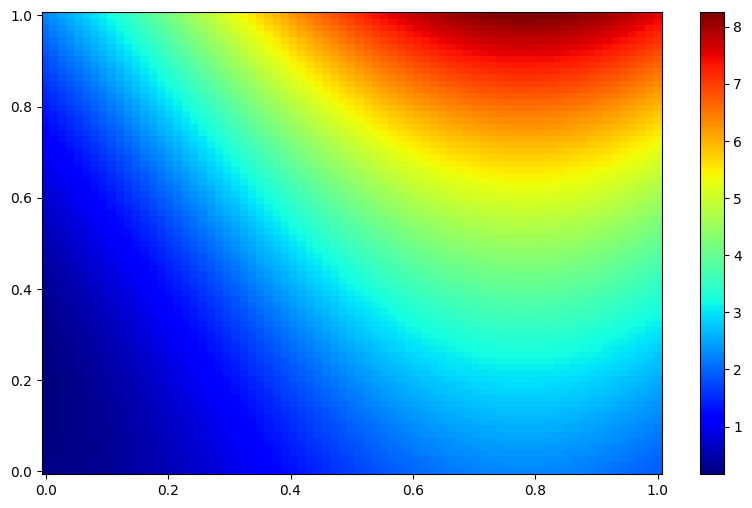

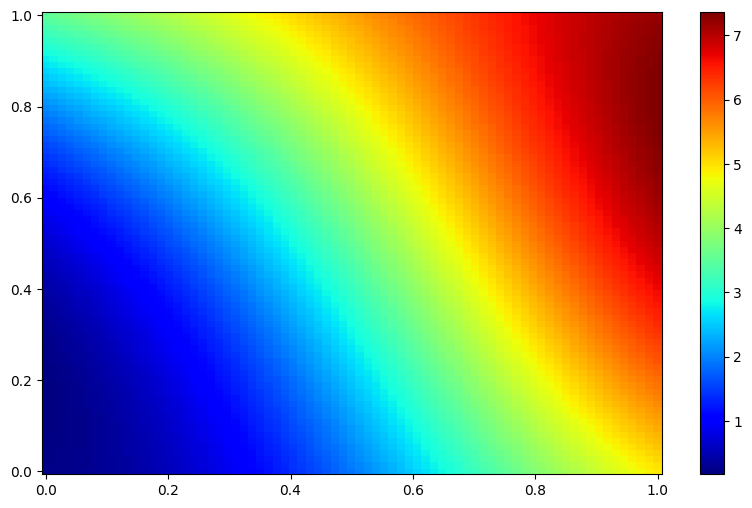

In [259]:
n1, n2 = 75, 75
xv, yv = torch.meshgrid([torch.linspace(0, 1, n1), torch.linspace(0, 1, n2)], indexing='ij')
test_X = torch.cat([xv.reshape(n1*n2, 1), yv.reshape(n1*n2, 1)], -1)
with torch.no_grad():
  ts_network.create_sample()
  test_Y = network_to_objective_transform(ts_network.query_sample(test_X.unsqueeze(1)))
  true_Y = network_to_objective_transform(function_network(test_X.unsqueeze(1)))
  # mean_Y = mean_function(test_X.unsqueeze(1))

print(f"Max of true function: {true_Y.max()}")
print(f"Max of TS function:   {test_Y.max()}")

from matplotlib import pyplot as plt
from matplotlib import cm

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
c = ax.pcolor(xv, yv, true_Y.detach().numpy().reshape(n1, n2), cmap=cm.jet)
fig.colorbar(c, ax=ax);

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
c = ax.pcolor(xv, yv, test_Y.detach().numpy().reshape(n1, n2), cmap=cm.jet)
fig.colorbar(c, ax=ax);

# fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# c = ax.pcolor(xv, yv, mean_Y.detach().numpy().reshape(n1, n2), cmap=cm.jet)
# fig.colorbar(c, ax=ax);

In [260]:
test_X = torch.tensor([[0.5, 0.5]])
print(network_to_objective_transform(ts_network.query_sample(test_X.unsqueeze(1))))
print(network_to_objective_transform(function_network(test_X.unsqueeze(1))))
print(mean_function(test_X.unsqueeze(1)))

tensor([[3.5180]], grad_fn=<SelectBackward0>)
tensor([[3.5991]])
tensor([3.5747], grad_fn=<SelectBackward0>)


In [261]:
from botorch.acquisition.knowledge_gradient import qKnowledgeGradient
from botorch.optim import optimize_acqf
from botorch.optim.initializers import (
    gen_batch_initial_conditions,
    gen_one_shot_kg_initial_conditions,
)

def optimize_acqf_and_get_suggested_point(
    acq_func,
    bounds,
    batch_size,
    posterior_mean=None,
    ) -> Tensor:
    """Optimizes the acquisition function, and returns a new candidate."""
    input_dim = bounds.shape[1]
    num_restarts=10*input_dim
    raw_samples=100*input_dim

    ic_gen = (
        gen_one_shot_kg_initial_conditions
        if isinstance(acq_func, qKnowledgeGradient)
        else gen_batch_initial_conditions
    )
    batch_initial_conditions = ic_gen(
        acq_function=acq_func,
        bounds=bounds,
        q=batch_size,
        num_restarts=num_restarts,
        raw_samples=raw_samples,
        options={"batch_limit": num_restarts},
    )

    if posterior_mean is not None:
        baseline_candidate, _ = optimize_acqf(
            acq_function=posterior_mean,
            bounds=bounds,
            q=batch_size,
            num_restarts=num_restarts,
            raw_samples=raw_samples,
            options={"batch_limit": 5},
        )

        if isinstance(acq_func, qKnowledgeGradient):
            augmented_q_batch_size = acq_func.get_augmented_q_batch_size(batch_size)
            baseline_candidate = baseline_candidate.detach().repeat(1, augmented_q_batch_size, 1)
        else:
            baseline_candidate = baseline_candidate.detach().view(torch.Size([1, batch_size, input_dim]))

        batch_initial_conditions = torch.cat([batch_initial_conditions, baseline_candidate], 0)
        num_restarts += 1

    candidate, acq_value = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=batch_size,
        num_restarts=num_restarts,
        raw_samples=raw_samples,
        batch_initial_conditions=batch_initial_conditions,
        options={"batch_limit": 2},
        #options={'disp': True, 'iprint': 101},
    )

    if baseline_candidate is not None:
        baseline_acq_value = acq_func.forward(baseline_candidate)[0].detach()
        print('Test begins')
        print(f"Optimized acq value: {acq_value}")
        print(f"Baseline acq value:  {baseline_acq_value}")
        print('Test ends')
        if baseline_acq_value >= acq_value:
            print('Baseline candidate was best found.')
            candidate = baseline_candidate

    new_x = candidate.detach().view([batch_size, input_dim])
    return new_x

In [262]:
import numpy as np
import os
import sys
import time
import torch
from botorch.acquisition import ExpectedImprovement, qExpectedImprovement, qKnowledgeGradient
from botorch.acquisition import PosteriorMean as GPPosteriorMean
from botorch.sampling.normal import SobolQMCNormalSampler
from torch import Tensor
from typing import Callable, List, Optional

def fit_gp_model(X, Y, Yvar=None):
    if Y.ndim == 1:
        Y = Y.unsqueeze(dim=-1)
    model = SingleTaskGP(train_X=X, train_Y=Y, train_Yvar=torch.ones(Y.shape) * 1e-5, outcome_transform=Standardize(m=1), covar_module=gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims = X.shape[1])))
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)
    return model

def get_new_suggested_point(
    algo: str,
    X: Tensor,
    network_output_at_X: Tensor,
    objective_at_X: Tensor,
    network_to_objective_transform: Callable,
    dag: DAG,
    active_input_indices: List[int],
) -> Tensor:
    input_dim = X.shape[-1]

    if algo == "Random":
        return torch.rand([1, input_dim])
    elif algo == "EIFN":
        # Model
        model = GaussianProcessNetwork(train_X=X, train_Y=network_output_at_X, dag=dag,
                          active_input_indices=active_input_indices)
        # Sampler
        qmc_sampler = SobolQMCNormalSampler(torch.Size([128]))
        # Acquisition function
        acquisition_function = qExpectedImprovement(
            model=model,
            best_f=objective_at_X.max().item(),
            sampler=qmc_sampler,
            objective=network_to_objective_transform,

        )
        posterior_mean_function = PosteriorMean(
            model=model,
            sampler=qmc_sampler,
            objective=network_to_objective_transform,
        )
    elif algo == "EICF":
        model = fit_gp_model(X=X, Y=network_output_at_X)
        qmc_sampler = SobolQMCNormalSampler(torch.Size([128]))
        acquisition_function = qExpectedImprovement(
            model=model,
            best_f=objective_at_X.max().item(),
            sampler=qmc_sampler,
            objective=network_to_objective_transform,

        )
        posterior_mean_function = PosteriorMean(
            model=model,
            sampler=qmc_sampler,
            objective=network_to_objective_transform,
        )
    elif algo == "EI":
        model = fit_gp_model(X=X, Y=objective_at_X)
        acquisition_function = ExpectedImprovement(
            model=model, best_f=objective_at_X.max().item())
        posterior_mean_function = GPPosteriorMean(model=model)
    elif algo == "KG":
        model = fit_gp_model(X=X, Y=objective_at_X)
        acquisition_function = qKnowledgeGradient(
            model=model, num_fantasies=8)
        posterior_mean_function = GPPosteriorMean(model=model)
    elif algo == "TSFN":
        # Model
        model = GaussianProcessNetwork(train_X=X, train_Y=network_output_at_X, dag=dag,
                          active_input_indices=active_input_indices)
        # Acqusition
        acquisition_function = ThompsonSampleFunctionNetwork(model, network_to_objective_transform)
        # Sampler
        qmc_sampler = SobolQMCNormalSampler(torch.Size([128]))
        posterior_mean_function = PosteriorMean(
            model=model,
            sampler=qmc_sampler,
            objective=network_to_objective_transform,
        )

    new_x = optimize_acqf_and_get_suggested_point(
        acq_func=acquisition_function,
        bounds=torch.tensor([[0. for i in range(input_dim)], [
                            1. for i in range(input_dim)]]),
        batch_size=1,
        posterior_mean=posterior_mean_function,
    )

    return new_x

def bofn_trial(
    problem: str,
    algo: str,
    trial:int,
    n_init_evals: int,
    n_bo_iter: int,
    restart: bool,
    function_network: Callable,
    dag: DAG,
    active_input_indices: List[List[Optional[int]]],
    input_dim: int,
    network_to_objective_transform: Callable,
) -> None:
    # Get script directory
    script_dir = os.path.dirname(os.path.realpath(sys.argv[0]))
    results_folder = script_dir + "/results/" + problem + "/" + algo + "/"

    if restart:
        # Check if training data is already available
        try:
            # Current available evaluations
            X = torch.tensor(np.loadtxt(results_folder +
                                        "X/X_" + str(trial) + ".txt"))
            network_output_at_X = torch.tensor(np.loadtxt(
                results_folder + "network_output_at_X/network_output_at_X_" + str(trial) + ".txt"))
            objective_at_X = torch.tensor(np.loadtxt(
                results_folder + "objective_at_X/objective_at_X_" + str(trial) + ".txt"))

            # Historical best observed objective values and running times
            hist_best_obs_vals = list(np.loadtxt(
                results_folder + "best_obs_vals_" + str(trial) + ".txt"))
            runtimes = list(np.loadtxt(
                results_folder + "runtimes/runtimes_" + str(trial) + ".txt"))

            # Current best observed objective value
            best_obs_val = torch.tensor(hist_best_obs_vals[-1])

            init_batch_id = len(hist_best_obs_vals)
            print("Restarting experiment from available data.")

        except:

            # Initial evaluations
            X = generate_initial_design(
                num_samples=n_init_evals, input_dim=input_dim, seed=trial)
            network_output_at_X = function_network(X)
            objective_at_X = network_to_objective_transform(
                network_output_at_X)

            # Current best objective value
            best_obs_val = objective_at_X.max().item()

            # Historical best observed objective values and running times
            hist_best_obs_vals = [best_obs_val]
            runtimes = []

            init_batch_id = 1
    else:
        # Initial evaluations
        X = generate_initial_design(
            num_samples=n_init_evals, input_dim=input_dim, seed=trial)
        network_output_at_X = function_network(X)
        objective_at_X = network_to_objective_transform(network_output_at_X)

        # Current best objective value
        best_obs_val = objective_at_X.max().item()

        # Historical best observed objective values and running times
        hist_best_obs_vals = [best_obs_val]
        runtimes = []

        init_batch_id = 1

    for iteration in range(init_batch_id, n_bo_iter + 1):
        print("Experiment: " + problem)
        print("Sampling policy: " + algo)
        print("Trial: " + str(trial))
        print("Iteration: " + str(iteration))

        # New suggested point
        t0 = time.time()
        new_x = get_new_suggested_point(
            algo=algo,
            X=X,
            network_output_at_X=network_output_at_X,
            objective_at_X=objective_at_X,
            network_to_objective_transform=network_to_objective_transform,
            dag=dag,
            active_input_indices=active_input_indices,
        )
        t1 = time.time()
        runtimes.append(t1 - t0)

        # Evalaute network at new point
        network_output_at_new_x = function_network(new_x)

        # Evaluate objective at new point
        objective_at_new_x = network_to_objective_transform(
            network_output_at_new_x)

        # Update training data
        X = torch.cat([X, new_x], 0)
        network_output_at_X = torch.cat(
            [network_output_at_X, network_output_at_new_x], 0)
        objective_at_X = torch.cat([objective_at_X, objective_at_new_x], 0)

        # Update historical best observed objective values
        best_obs_val = objective_at_X.max().item()
        hist_best_obs_vals.append(best_obs_val)
        print("Best value found so far: " + str(best_obs_val))

        # Save data
        np.savetxt(results_folder + "X/X_" + str(trial) + ".txt", X.numpy())
        np.savetxt(results_folder + "network_output_at_X/network_output_at_X_" +
                   str(trial) + ".txt", network_output_at_X.numpy())
        np.savetxt(results_folder + "objective_at_X/objective_at_X_" +
                   str(trial) + ".txt", objective_at_X.numpy())
        np.savetxt(results_folder + "best_obs_vals_" +
                   str(trial) + ".txt", np.atleast_1d(hist_best_obs_vals))
        np.savetxt(results_folder + "runtimes/runtimes_" +
                   str(trial) + ".txt", np.atleast_1d(runtimes))

def experiment_manager(
    problem: str,
    algo: str,
    first_trial: int,
    last_trial: int,
    n_init_evals: int,
    n_bo_iter: int,
    restart: bool,
    function_network: Callable,
    dag: DAG,
    active_input_indices: List[List[Optional[int]]],
    input_dim: int,
    network_to_objective_transform: Callable,
) -> None:
    # Get script directory
    script_dir = os.path.dirname(os.path.realpath(sys.argv[0]))
    results_folder = script_dir + "/results/" + problem + "/" + algo + "/"

    if not os.path.exists(results_folder) :
        os.makedirs(results_folder)
    if not os.path.exists(results_folder + "runtimes/"):
        os.makedirs(results_folder + "runtimes/")
    if not os.path.exists(results_folder + "X/"):
        os.makedirs(results_folder + "X/")
    if not os.path.exists(results_folder + "network_output_at_X/"):
        os.makedirs(results_folder + "network_output_at_X/")
    if not os.path.exists(results_folder + "objective_at_X/"):
        os.makedirs(results_folder + "objective_at_X/")

    for trial in range(first_trial, last_trial + 1):
        bofn_trial(
            problem=problem,
            function_network=function_network,
            network_to_objective_transform=network_to_objective_transform,
            input_dim=input_dim,
            dag=dag,
            active_input_indices=active_input_indices,
            algo=algo,
            n_init_evals=n_init_evals,
            n_bo_iter=n_bo_iter,
            trial=trial,
            restart=restart,
        )

In [264]:
# Run experiment
algo = "TSFN"

n_bo_iter = 20

first_trial = 1
last_trial = 2

experiment_manager(
    problem=problem,
    algo=algo,
    first_trial=first_trial,
    last_trial=last_trial,
    n_init_evals=2*(input_dim + 1),
    n_bo_iter=n_bo_iter,
    restart=True,
    function_network=function_network,
    dag=dag,
    active_input_indices=active_input_indices,
    input_dim=input_dim,
    network_to_objective_transform=network_to_objective_transform,
)

Restarting experiment from available data.
Experiment: sinwave
Sampling policy: TSFN
Trial: 1
Iteration: 6


/usr/local/lib/python3.10/dist-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Test begins
Optimized acq value: 8.2457611630316
Baseline acq value:  8.24520183949201
Test ends
Best value found so far: 8.249791342254046
Experiment: sinwave
Sampling policy: TSFN
Trial: 1
Iteration: 7


/usr/local/lib/python3.10/dist-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Test begins
Optimized acq value: 8.24881557064442
Baseline acq value:  8.248696212343436
Test ends
Best value found so far: 8.249894262827596
Experiment: sinwave
Sampling policy: TSFN
Trial: 1
Iteration: 8


/usr/local/lib/python3.10/dist-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


Test begins
Optimized acq value: 8.25198067695808
Baseline acq value:  8.250799843857964
Test ends
Best value found so far: 8.249894262827596
Experiment: sinwave
Sampling policy: TSFN
Trial: 1
Iteration: 9
Test begins
Optimized acq value: 8.251501654815243
Baseline acq value:  8.251159199661577
Test ends
Best value found so far: 8.249894262827596
Experiment: sinwave
Sampling policy: TSFN
Trial: 1
Iteration: 10
Test begins
Optimized acq value: 8.249622201392768
Baseline acq value:  8.248983424139336
Test ends
Best value found so far: 8.249894262827596
Experiment: sinwave
Sampling policy: TSFN
Trial: 1
Iteration: 11
Test begins
Optimized acq value: 8.253349063606471
Baseline acq value:  8.25195079803662
Test ends
Best value found so far: 8.249894262827596
Experiment: sinwave
Sampling policy: TSFN
Trial: 1
Iteration: 12
Test begins
Optimized acq value: 8.247327481959301
Baseline acq value:  8.246959432316398
Test ends
Best value found so far: 8.249894262827596
Experiment: sinwave
Sampling

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Test begins
Optimized acq value: 8.248106490888057
Baseline acq value:  8.248069734041213
Test ends
Best value found so far: 8.249999847492926
Experiment: sinwave
Sampling policy: TSFN
Trial: 1
Iteration: 20
Test begins
Optimized acq value: 8.246914340579147
Baseline acq value:  8.246331694192966
Test ends
Best value found so far: 8.249999847492926
Restarting experiment from available data.
Experiment: sinwave
Sampling policy: TSFN
Trial: 2
Iteration: 6


/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Test begins
Optimized acq value: 8.338213797790829
Baseline acq value:  8.334494444780182
Test ends
Best value found so far: 8.248669349235067
Experiment: sinwave
Sampling policy: TSFN
Trial: 2
Iteration: 7
Test begins
Optimized acq value: 8.238453573420783
Baseline acq value:  8.231981128482673
Test ends
Best value found so far: 8.248669349235067
Experiment: sinwave
Sampling policy: TSFN
Trial: 2
Iteration: 8
Test begins
Optimized acq value: 8.223119286562579
Baseline acq value:  8.22100773143566
Test ends
Best value found so far: 8.248669349235067
Experiment: sinwave
Sampling policy: TSFN
Trial: 2
Iteration: 9
Test begins
Optimized acq value: 8.214800214661508
Baseline acq value:  8.205136079715635
Test ends
Best value found so far: 8.248669349235067
Experiment: sinwave
Sampling policy: TSFN
Trial: 2
Iteration: 10
Test begins
Optimized acq value: 8.243911016724859
Baseline acq value:  8.240793735453844
Test ends
Best value found so far: 8.248669349235067
Experiment: sinwave
Sampling 

/usr/local/lib/python3.10/dist-packages/botorch/optim/optimize.py:367: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Test begins
Optimized acq value: 8.240664347217725
Baseline acq value:  8.240440385705739
Test ends
Best value found so far: 8.249997760429812
Experiment: sinwave
Sampling policy: TSFN
Trial: 2
Iteration: 16
Test begins
Optimized acq value: 8.238006807032455
Baseline acq value:  8.237866782033684
Test ends
Best value found so far: 8.249997760429812
Experiment: sinwave
Sampling policy: TSFN
Trial: 2
Iteration: 17
Test begins
Optimized acq value: 8.250983423804987
Baseline acq value:  8.25078859317958
Test ends
Best value found so far: 8.249998082932791
Experiment: sinwave
Sampling policy: TSFN
Trial: 2
Iteration: 18
Test begins
Optimized acq value: 8.246555259845763
Baseline acq value:  8.24639883510283
Test ends
Best value found so far: 8.249998082932791
Experiment: sinwave
Sampling policy: TSFN
Trial: 2
Iteration: 19
Test begins
Optimized acq value: 8.27325338623664
Baseline acq value:  8.272818317184209
Test ends
Best value found so far: 8.249998082932791
Experiment: sinwave
Sampling